In [ ]:
import os
import torch
import rasterio
import numpy as np
from torch.utils.data import Dataset, DataLoader
import glob

!pip install -q einops
import os
import numpy as np
import matplotlib.pyplot as plt
import glob

import torch
from torchvision import transforms
import torch.nn as nn
import torch.utils.data as data
from torch.utils.data import DataLoader

import torch.nn.functional as F
from torch.autograd import Variable
import math
from math import exp
from tqdm import tqdm

from kornia.filters.sobel import Sobel
import wandb
from torchvision.utils import make_grid
import gc
from torchmetrics import StructuralSimilarityIndexMeasure as SSIM


import matplotlib.pyplot as plt
from torch.nn.parameter import Parameter
from einops import rearrange
from torch.nn import init 


In [210]:
class DEMDataset(Dataset):
    """Dataset class for handling DEM files"""
    def __init__(self, 
                 data_dir,
                 batch_size=4):
        self.data_dir = data_dir
        self.batch_size = batch_size
        
        # Get all .pt files
        self.file_list = glob.glob(self.data_dir+"*.pt")
        if '../data_DEMs_no_nan/test/NAC_DTM_MESSIER3_block_211.pt' in self.file_list:
            self.file_list.remove('../data_DEMs_no_nan/test/NAC_DTM_MESSIER3_block_211.pt')
        
        # Store normalization parameters for each file
        self.norm_params = {}
        self._compute_normalization_params()
        
    def _compute_normalization_params(self):
        """Compute min and max values for each DEM file"""
        for file_name in self.file_list:
            data = torch.load(file_name)
            self.norm_params[file_name] = {
                'min': float(data.min()),
                'max': float(data.max())
            }
                
    def normalize(self, data, file_name):
        """Normalize data to range [0, 1]"""
        min_val = self.norm_params[file_name]['min']
        max_val = self.norm_params[file_name]['max']
        return (data - min_val) / (max_val - min_val)
    
    def unnormalize(self, data, file_name):
        """Un-normalize data back to original scale"""
        min_val = self.norm_params[file_name]['min']
        max_val = self.norm_params[file_name]['max']
        return data * (max_val - min_val) + min_val
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        file_path = self.file_list[idx]
        # file_path = os.path.join(self.data_dir, file_name)
        
        im = torch.load(file_path)
        
        if not isinstance(im, torch.Tensor):
            im = torch.tensor(im, dtype=torch.float32)
        
        im = self.normalize(im, file_path)
        
        if im.dim() == 2:
            im = im.unsqueeze(0)
        
        HR = im.float()
        LR = self._bilinear_downsample(HR)
        
        HR = HR.squeeze()
        LR = LR.squeeze().float()
        
        data = (HR,LR)

        return data, file_path
    
    def _bilinear_downsample(self, HR):
        """Bilinear downsampling"""
        return torch.nn.functional.interpolate(HR.unsqueeze(0), scale_factor=0.5, mode='bilinear').squeeze()

In [211]:
def get_dem_dataloader(data_dir,
                      batch_size = 32,
                      shuffle = False):
    """
    Create DataLoader for DEM files
    
    Returns:
        DataLoader and Dataset objects
    """
    dataset = DEMDataset(data_dir, batch_size)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
    )
    return dataloader, dataset

In [ ]:
# data_dir : data in which you DEM .pt files are located
# batch_size : number of DEM files to be processed at once.

testloader,testset = get_dem_dataloader(data_dir='malapertMassif/',batch_size=4)

In [ ]:
# Defining Deep learning super resolution Model

class depthwise_separable_conv(nn.Module):
    def __init__(self, nin, nout, kernel_size = 3, padding = 1, bias=False):
        super(depthwise_separable_conv, self).__init__()
        self.depthwise = nn.Conv2d(nin, nin, kernel_size=kernel_size, padding=padding, groups=nin, bias=bias)
        self.pointwise = nn.Conv2d(nin, nout, kernel_size=1, bias=bias)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

class ERAM(nn.Module):
    def __init__(self, channel_begin, dimension):
        super().__init__()
        self.conv = nn.Conv2d(channel_begin, channel_begin, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.avgpool = nn.AvgPool2d(dimension)
        
        self.conv1 = nn.Conv2d(channel_begin, channel_begin//2, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(channel_begin//2, channel_begin, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(channel_begin, channel_begin, kernel_size=3, stride=1, padding=1)

        self.dconv = depthwise_separable_conv(channel_begin, channel_begin, kernel_size = 3, padding = 1, bias=False)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        si_ca = self.avgpool(x) + torch.var_mean(x, dim=(2,3))[0].unsqueeze(2).unsqueeze(2)
        mi_ca = self.conv2(self.relu(self.conv1(si_ca)))

        mi_sa = self.conv3(self.relu(self.dconv(x)))

        return self.sigmoid(mi_ca+mi_sa) * x

    

class SelfAttn(nn.Module):
    def __init__(self, dim, num_heads=8, bias=False):
        super(SelfAttn, self).__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=bias)
        self.proj_out = nn.Linear(dim, dim)

    def forward(self, x):
        b, N, c = x.shape

        qkv = self.qkv(x).chunk(3, dim=-1)
        # [b, N, c] -> [b, N, head, c//head] -> [b, head, N, c//head]
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.num_heads), qkv)

        # [b, head, N, c//head] * [b, head, N, c//head] -> [b, head, N, N]
        attn = torch.einsum('bijc, bikc -> bijk', q, k) * self.scale
        attn = attn.softmax(dim=-1)
        # [b, head, N, N] * [b, head, N, c//head] -> [b, head, N, c//head] -> [b, N, head, c//head]
        x = torch.einsum('bijk, bikc -> bijc', attn, v)
        x = rearrange(x, 'b i j c -> b j (i c)')
        x = self.proj_out(x)
        return x


class Mlp(nn.Module):
    def __init__(self, in_features, mlp_ratio=4):
        super(Mlp, self).__init__()
        hidden_features = in_features * mlp_ratio

        self.fc = nn.Sequential(
            nn.Linear(in_features, hidden_features),
            nn.GELU(),
            nn.Linear(hidden_features, in_features)
        )

    def forward(self, x):
        return self.fc(x)


def window_partition(x, window_size):
    """
    Args:
        x: (b, h, w, c)
        window_size (int): window size
    Returns:
        windows: (num_windows*b, window_size, window_size, c) [non-overlap]
    """
    return rearrange(x, 'b (h s1) (w s2) c -> (b h w) s1 s2 c', s1=window_size, s2=window_size)


def window_reverse(windows, window_size, h, w):
    """
    Args:
        windows: (num_windows*B, window_size, window_size, C)
        window_size (int): Window size
        h (int): Height of image
        w (int): Width of image
    Returns:
        x: (b, h, w, c)
    """
    b = int(windows.shape[0] / (h * w / window_size / window_size))
    return rearrange(windows, '(b h w) s1 s2 c -> b (h s1) (w s2) c', b=b, h=h // window_size, w=w // window_size)


class Transformer(nn.Module):
    def __init__(self, dim, num_heads=4, window_size=8, mlp_ratio=4, qkv_bias=False):
        super(Transformer, self).__init__()
        self.window_size = window_size
        self.pos_embed = nn.Conv2d(dim, dim, 3, padding=1, groups=dim)

        self.norm1 = nn.LayerNorm(dim)
        self.attn = SelfAttn(dim, num_heads, qkv_bias)
        self.norm2 = nn.LayerNorm(dim)

        self.mlp = Mlp(dim, mlp_ratio)
        # self.rrdBAtt = RRDBAttention(256,32)


    def forward(self, x):
        x = x + self.pos_embed(x)
        x = rearrange(x, 'b c h w -> b h w c')
        b, h, w, c = x.shape

        shortcut = x
        x = self.norm1(x)

        pad_l = pad_t = 0
        pad_r = (self.window_size - w % self.window_size) % self.window_size
        pad_b = (self.window_size - h % self.window_size) % self.window_size
        x = F.pad(x, (0, 0, pad_l, pad_r, pad_t, pad_b))
        _, Hp, Wp, _ = x.shape

        x_windows = window_partition(x, self.window_size)  # nW*B, window_size, window_size, c
        x_windows = rearrange(x_windows, 'B s1 s2 c -> B (s1 s2) c', s1=self.window_size,
                              s2=self.window_size)  # nW*b, window_size*window_size, c

        # W-MSA/SW-MSA
        # print("shape before : ",x_windows.shape)
        attn_windows = self.attn(x_windows)  # nW*b, window_size*window_size, c

        # x_windows = x_windows.view(b,256,64,-1)

        # attn_windows = self.rrdBAtt(x_windows)

        attn_windows = attn_windows.reshape(b*256,64,-1)

        # print("shape after : ",x_windows.shape)
        # merge windows
        attn_windows = rearrange(attn_windows, 'B (s1 s2) c -> B s1 s2 c', s1=self.window_size, s2=self.window_size)
        x = window_reverse(attn_windows, self.window_size, Hp, Wp)  # b H' W' c

        # reverse cyclic shift
        if pad_r > 0 or pad_b > 0:
            x = x[:, :h, :w, :].contiguous()

        x = x + shortcut
        x = x + self.mlp(self.norm2(x))
        return rearrange(x, 'b h w c -> b c h w')


class ResBlock(nn.Module):
    def __init__(self, in_features, ratio=4):
        super(ResBlock, self).__init__()

        self.net = nn.Sequential(
            nn.Conv2d(in_features, in_features * ratio, 1, 1, 0),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_features * ratio, in_features * ratio, 3, 1, 1, groups=in_features * ratio),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_features * ratio, in_features, 1, 1, 0),
        )

    def forward(self, x):
        return self.net(x) + x


class BaseBlock(nn.Module):
    def __init__(self, dim, num_heads=8, window_size=8, ratios=[1, 2, 2, 4, 4], qkv_bias=False):
        super(BaseBlock, self).__init__()
        self.layers = nn.ModuleList([])
        # self.eram = ERAM(dim,128)
#         print('dim : ',dim)
        for ratio in ratios:
            self.layers.append(nn.ModuleList([
                Transformer(dim, num_heads, window_size, ratio, qkv_bias),
                ResBlock(dim, ratio),
                ERAM(dim,128) # this 128 represent the size of square input DEM, like 128x128  
            ]))

    def forward(self, x):
        for tblock, rblock ,eram in self.layers:
            x = tblock(x)
            x = rblock(x)
            x = eram(x)
        return x


class SRModel(nn.Module):
    def __init__(self, n_feats=40, n_heads=8, ratios=[4, 2, 2, 2, 4], upscaling_factor=2):
        super(SRModel, self).__init__()
        self.scale = upscaling_factor
        self.head = nn.Conv2d(1, n_feats, 3, 1, 1)

        self.body = BaseBlock(n_feats, num_heads=n_heads, ratios=ratios)

        self.fuse = nn.Conv2d(n_feats * 2, n_feats, 3, 1, 1)

        if self.scale == 4:
            self.upsapling = nn.Sequential(
                nn.Conv2d(n_feats, n_feats * 4, 1, 1, 0),
                nn.PixelShuffle(2),
                nn.Conv2d(n_feats, n_feats * 4, 1, 1, 0),
                nn.PixelShuffle(2)
            )
        else:
            self.upsapling = nn.Sequential(
                nn.Conv2d(n_feats, n_feats * self.scale * self.scale, 1, 1, 0),
                nn.PixelShuffle(self.scale)
            )

        self.tail = nn.Conv2d(n_feats, 1, 3, 1, 1)
        self.act = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        x0 = self.head(x)
        x0 = self.fuse(torch.cat([x0, self.body(x0)], dim=1))
        x0 = self.upsapling(x0)
        x0 = self.tail(self.act(x0))
        x = F.interpolate(x, scale_factor=self.scale, mode='bicubic', align_corners=False)
        return (torch.tanh(x0 + x) +1.0)/2.0

network = SRModel()

#checking on random input tensor to test whether the model has been intiialized properly or no
inp = torch.rand([1,1,128,128])
out = network(inp)
print(out.shape)

torch.Size([1, 1, 256, 256])


In [215]:
def process_dem_data(data_dir,
                    model,
                    device,
                    batch_size):
    """
    Process DEM data through the super-resolution model
    """

    dataloader, dataset = get_dem_dataloader(data_dir, batch_size)
    
    # Dictionary to store results
    results = {}
    
    model.eval()
    with torch.no_grad():
        for batch, file_names in dataloader:
            # Move hr,lr to device
            HR,LR = batch
            HR = HR.unsqueeze(1).to(device)
            LR = LR.unsqueeze(1).to(device)
            
            output = model(LR)
            
            # Move output back to CPU and unnormalize
            output = output.cpu()
            
            # Store unnormalized results
            for i, file_name in enumerate(file_names):
                lr_unnorm = dataset.unnormalize(LR[i], file_name)
                hr_unnorm = dataset.unnormalize(HR[i], file_name)
                output_unnorm = dataset.unnormalize(output[i], file_name)
                results[file_name] = {
                    'lr': lr_unnorm,
                    'hr': hr_unnorm,
                    'output': output_unnorm
                }
    
    return results

In [ ]:
network.to('cuda') # select a device on which model will be inferenced, if using GPU : 'cuda' else for cpu : 'cpu'
network.load_state_dict(torch.load('fintunedWeight_MultiDownsampling.pt')) # loading a pretrained weight for the model
dem_results = process_dem_data(data_dir='malapertMassif/',model = network, device='cuda',batch_size=4) # pass the input directory and batch_size

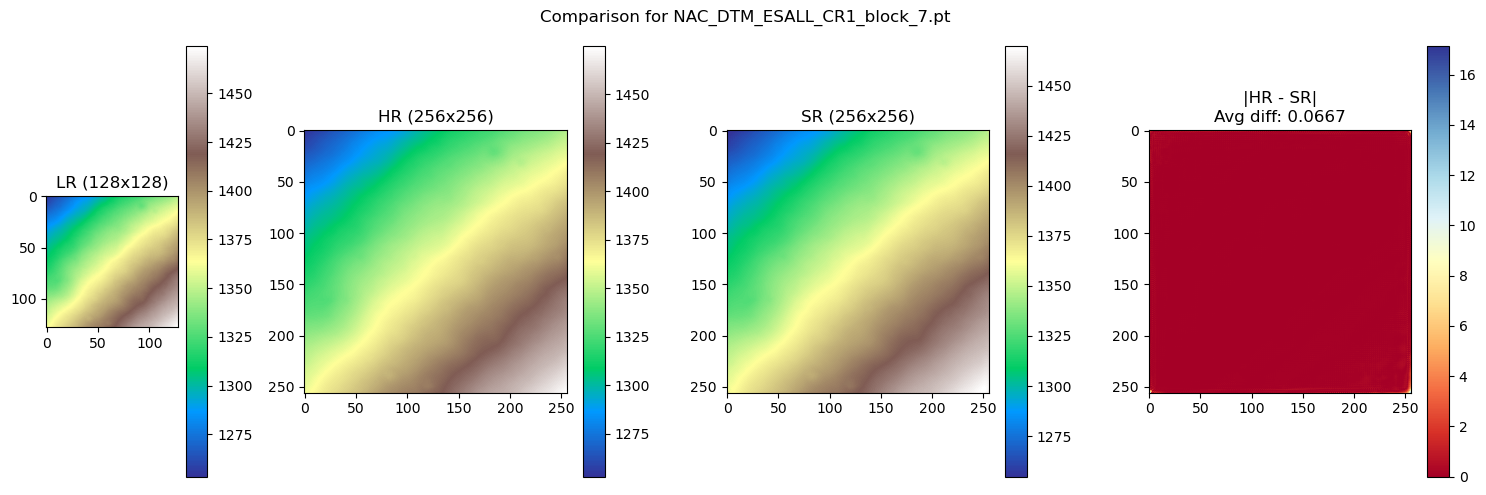

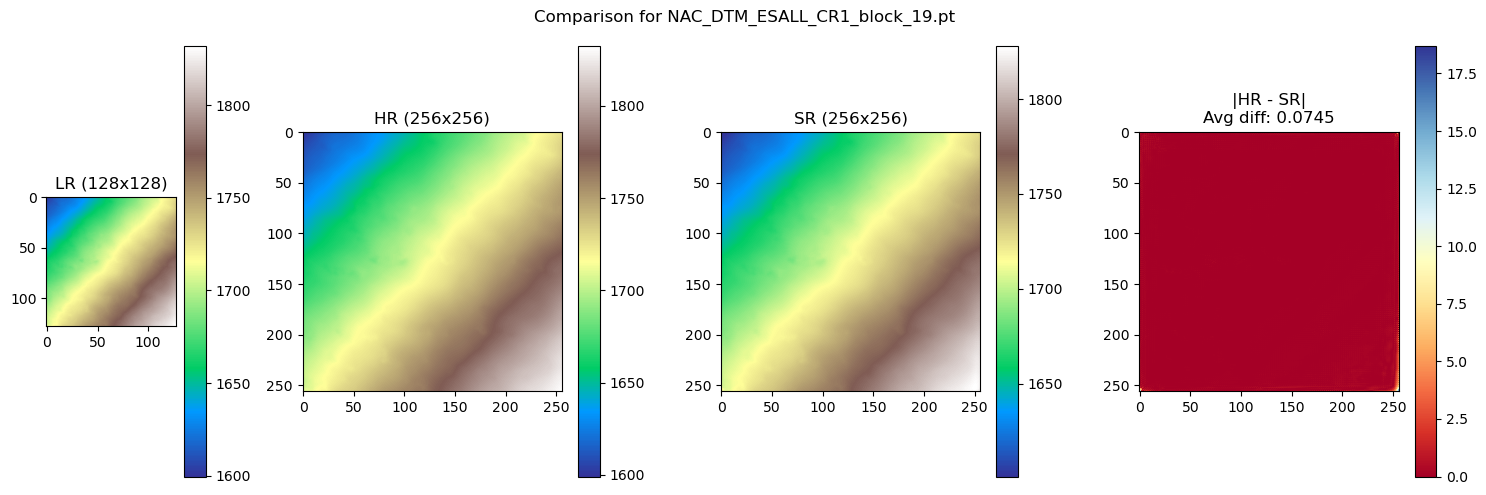

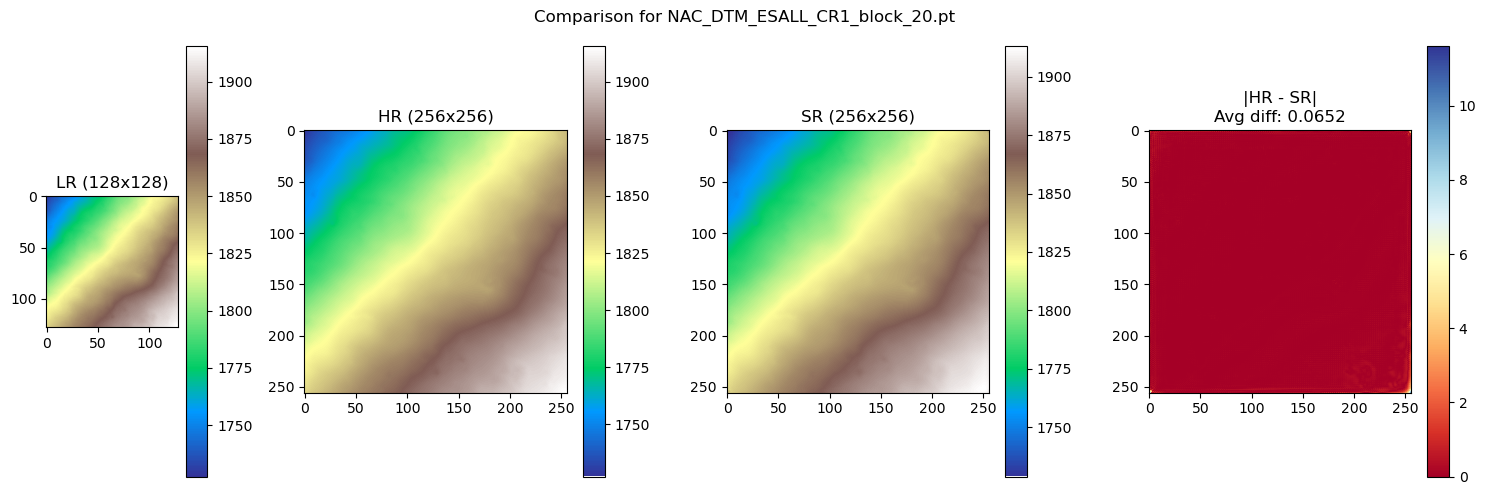

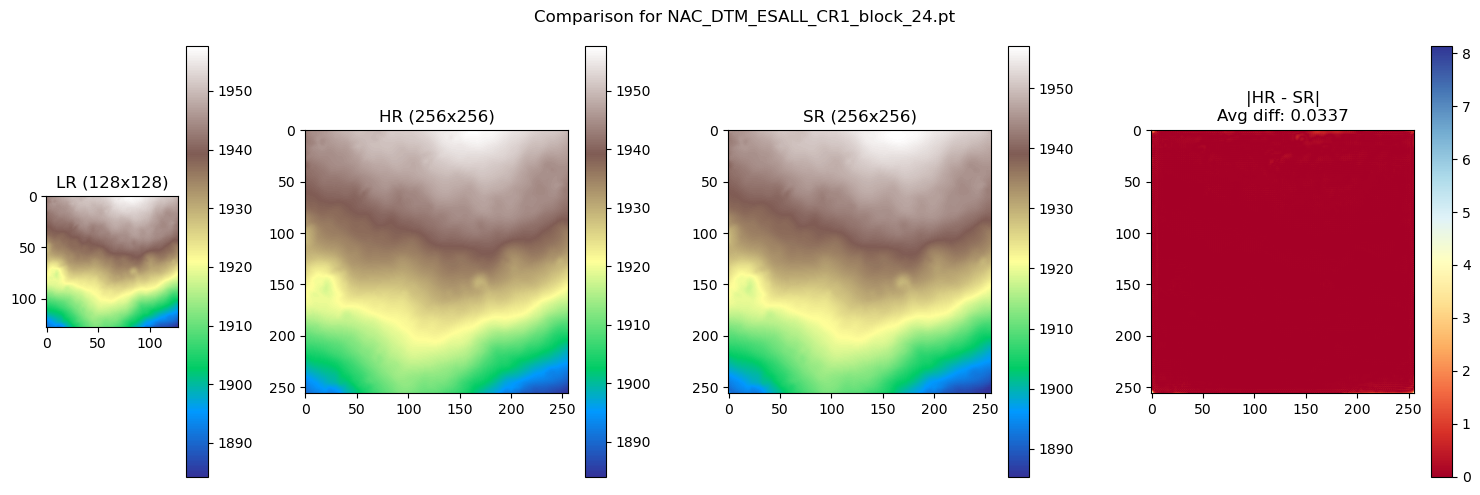

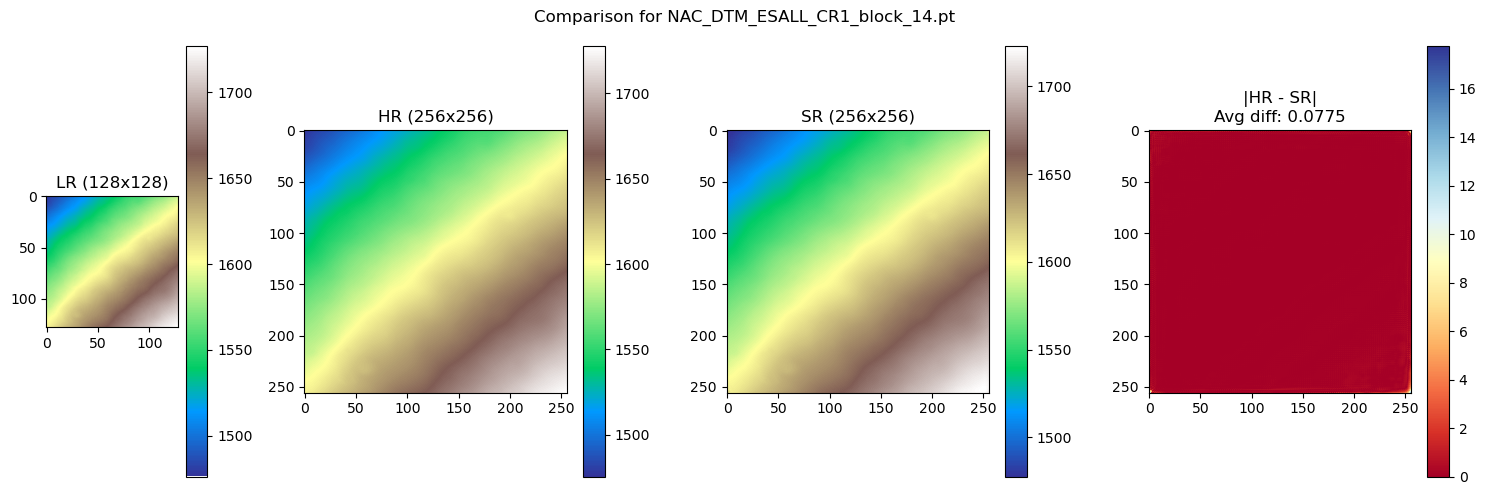

In [ ]:
def visualize_results(results, filename, figsize=(20, 5)):
    """
    Visualize LR, HR, SR images and the difference map (HR-SR) side by side
    
    Args:
        results (dict): Dictionary containing LR, HR, and SR images
        filename (str): Filename for the title
        figsize (tuple): Figure size
    """

    lr_img = results[filename]['lr'].squeeze().cpu().numpy()
    hr_img = results[filename]['hr'].squeeze().cpu().numpy()
    sr_img = results[filename]['output'].squeeze().cpu().numpy()
    
    diff_map = np.abs(hr_img - sr_img)
    
    fig = plt.figure(figsize=figsize)
    
    gs = plt.GridSpec(1, 4, width_ratios=[1, 2, 2, 2])
    
    ax0 = plt.subplot(gs[0])
    im0 = ax0.imshow(lr_img, cmap='terrain')
    ax0.set_title(f'LR ({lr_img.shape[0]}x{lr_img.shape[1]})')
    plt.colorbar(im0, ax=ax0)
    
    ax1 = plt.subplot(gs[1])
    im1 = ax1.imshow(hr_img, cmap='terrain')
    ax1.set_title(f'HR ({hr_img.shape[0]}x{hr_img.shape[1]})')
    plt.colorbar(im1, ax=ax1)
    
    ax2 = plt.subplot(gs[2])
    im2 = ax2.imshow(sr_img, cmap='terrain')
    ax2.set_title(f'SR ({sr_img.shape[0]}x{sr_img.shape[1]})')
    plt.colorbar(im2, ax=ax2)
    
    ax3 = plt.subplot(gs[3])
    im3 = ax3.imshow(diff_map, cmap='RdYlBu')
    ax3.set_title(f'|HR - SR|\nAvg diff: {diff_map.mean():.4f}')
    plt.colorbar(im3, ax=ax3)
    
    plt.suptitle(f'Comparison for {os.path.basename(filename)}')
    
    plt.tight_layout()
    
    return fig


def visualize(data_dir, model, device, batch_size, num_samples=3):
    """
    visualize results
    """
    results = process_dem_data(data_dir, model, device, batch_size)
    figs = visualize_multiple_samples(results, num_samples=num_samples)
    
    return figs

figs = visualize(
    data_dir='connectingRidgeData/',
    model=network,
    device='cuda',
    batch_size=4,
    num_samples=5 # enter the number of samples to be visualize 
)

In [218]:
def visualize_and_save_results(results, filename, save_dir, figsize=(20, 5)):
    """
    Visualize and save LR, HR, SR images and the difference map separately
    
    Args:
        results (dict): Dictionary containing the images
        filename (str): Original filename
        save_dir (str): Directory to save the images
        figsize (tuple): Figure size for combined plot
    """
    # Create save directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Get base filename without extension and directory
    base_filename = os.path.splitext(os.path.basename(filename))[0]
    
    # Get images
    lr_img = results[filename]['lr'].squeeze().cpu().numpy()
    hr_img = results[filename]['hr'].squeeze().cpu().numpy()
    sr_img = results[filename]['output'].squeeze().cpu().numpy()
    
    # Calculate difference map
    diff_map = np.abs(hr_img - sr_img)
    avg_diff = np.mean(diff_map)
    
    # Function to save individual plots
    def save_subplot(img, title, filename, cmap='terrain'):
        plt.figure(figsize=(8, 8))
        im = plt.imshow(img, cmap=cmap)
        plt.colorbar(im)
        plt.title(title)
        plt.savefig(filename, bbox_inches='tight', dpi=300)
        plt.close()
    
    # Save individual plots
    save_subplot(
        lr_img, 
        f'LR ({lr_img.shape[0]}x{lr_img.shape[1]})', 
        os.path.join(save_dir, f'{base_filename}_LR.png')
    )
    
    save_subplot(
        hr_img, 
        f'HR ({hr_img.shape[0]}x{hr_img.shape[1]})', 
        os.path.join(save_dir, f'{base_filename}_HR.png')
    )
    
    save_subplot(
        sr_img, 
        f'SR ({sr_img.shape[0]}x{sr_img.shape[1]})', 
        os.path.join(save_dir, f'{base_filename}_SR.png')
    )
    
    save_subplot(
        diff_map, 
        f'|HR - SR|\nAvg diff: {avg_diff:.4f}', 
        os.path.join(save_dir, f'{base_filename}_DIFF.png'),
        cmap='RdYlBu'
    )
    
    # Create and save combined plot
    fig = plt.figure(figsize=figsize)
    gs = plt.GridSpec(1, 4, width_ratios=[1, 2, 2, 2])
    
    # Plot LR image
    ax0 = plt.subplot(gs[0])
    im0 = ax0.imshow(lr_img, cmap='terrain')
    ax0.set_title(f'LR ({lr_img.shape[0]}x{lr_img.shape[1]})')
    plt.colorbar(im0, ax=ax0)
    
    # Plot HR image
    ax1 = plt.subplot(gs[1])
    im1 = ax1.imshow(hr_img, cmap='terrain')
    ax1.set_title(f'HR ({hr_img.shape[0]}x{hr_img.shape[1]})')
    plt.colorbar(im1, ax=ax1)
    
    # Plot SR image
    ax2 = plt.subplot(gs[2])
    im2 = ax2.imshow(sr_img, cmap='terrain')
    ax2.set_title(f'SR ({sr_img.shape[0]}x{sr_img.shape[1]})')
    plt.colorbar(im2, ax=ax2)
    
    # Plot difference map
    ax3 = plt.subplot(gs[3])
    im3 = ax3.imshow(diff_map, cmap='RdYlBu')
    ax3.set_title(f'|HR - SR|\nAvg diff: {avg_diff:.4f}')
    plt.colorbar(im3, ax=ax3)
    
    plt.suptitle(f'Comparison for {base_filename}')
    plt.tight_layout()
    
    # Save combined plot
    fig.savefig(os.path.join(save_dir, f'{base_filename}_combined.png'), 
                bbox_inches='tight', dpi=600)
    plt.close(fig)

def save_visualizations(results, save_dir, num_samples=None):
    """
    Process and save visualizations for multiple samples
    
    Args:
        results (dict): Dictionary containing all results
        save_dir (str): Directory to save the images
        num_samples (int): Number of samples to process (None for all)
    """
    filenames = list(results.keys())
    
    if num_samples is not None and num_samples < len(filenames):
        filenames = np.random.choice(filenames, num_samples, replace=False)
    
    for filename in filenames:
        print(f"Processing {os.path.basename(filename)}...")
        visualize_and_save_results(results, filename, save_dir)


save_dir = 'demoOutput/cr'
save_visualizations(
    results=dem_results,  
    save_dir=save_dir,
    num_samples=5 
)

Processing NAC_DTM_ESALL_MP1_block_33.pt...
Processing NAC_DTM_ESALL_MP1_block_17.pt...
Processing NAC_DTM_ESALL_MP1_block_5.pt...
Processing NAC_DTM_ESALL_MP1_block_19.pt...
Processing NAC_DTM_ESALL_MP1_block_30.pt...
